# Project 3 — Link Analysis: PageRank Variants on Amazon Books  
**Course:** Algorithms for Massive Data  
**Program:** Master in Data Science for Economics — University of Milan  

---

### Project Description
The goal of this project is to design and implement a ranking system based on the **PageRank** algorithm.  
The analysis is performed on the *Amazon Books Review* dataset (`Books_rating.csv`).  

In this work, we explore alternative graph constructions and ranking strategies.  
Books are represented as nodes and are linked together when they have been reviewed by at least two different users.  
The resulting network allows us to study the difference between **popularity** (number of reviews) and **prestige** (PageRank influence).

The notebook is organized in clear sections that reflect the main steps of the work:

1. **Introduction & Motivation** – overview of the PageRank idea and why it fits the Amazon Books network  
2. **Dataset & Pre-processing** – data cleaning and graph construction  
3. **Methods** – implementation of PageRank and its main extensions (personalized, temporal, reputation-based, and genre-based)  
4. **Experiments & Evaluation** – testing the algorithms and comparing rankings  
  
---


## 1. Introduction & Motivation

Networks often reveal information that simple counts cannot capture.  
In this project, I work with the **Amazon Books Review** dataset, where books are connected if they have been reviewed by at least two common users.  
This graph structure allows me to study how user interactions shape the relative *importance* of books within the review network.

The main objective is to design a **ranking system** based on the PageRank algorithm.  
While traditional metrics such as the number of reviews measure **popularity**, they may not reflect **quality** or **prestige** — a book can be widely reviewed but not necessarily influential within the network.  
PageRank helps reduce this bias by rewarding books that are connected to other highly regarded books, not only those that accumulate many reviews.

Throughout the notebook, I implement and compare several **PageRank variants** to explore different perspectives on influence:
- **Vanilla PageRank** – the baseline formulation  
- **Personalized PageRank** – focusing on specific thematic or user preferences  
- **Temporal Decay PageRank** – giving more weight to recent activity  
- **Reviewer-Reputation PageRank** – adjusting edges by reviewer reliability  
- **Genre-Specialized PageRank** – evaluating influence within thematic sub-networks  

The experiments aim to answer a central question:  
> *Does popularity always imply prestige, or can less popular books still emerge as influential when network structure is considered?*

This section motivates the study and frames the problem of popularity bias; the following sections describe the environment setup and implementation details.



##  Environment & Reproducibility

This section sets up a clean and reproducible environment for the experiments.  
Random seeds are fixed to make the results stable, and display options are adjusted for clearer output.Essential libraries are imported here.


In [1]:
# ---- 0) Imports & Config ----
from __future__ import annotations

# stdlib
import os
import sys
import math
import json
import platform
import random
from datetime import datetime
import warnings

# numeric / data
import numpy as np
import pandas as pd

# sparse linear algebra
from scipy import sparse
from scipy.sparse import csr_matrix, csc_matrix
from scipy.sparse.linalg import norm as sparse_norm

# statistics
from scipy.stats import kendalltau, spearmanr, pearsonr

# plotting
import matplotlib.pyplot as plt

# graphs (for HITS / sanity checks)
import networkx as nx

# display & reproducibility
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)
pd.options.mode.chained_assignment = None  # silence SettingWithCopy in controlled sections

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

warnings.filterwarnings("ignore")

ENV_INFO = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "timestamp": datetime.now().isoformat(timespec="seconds"),
}
print(ENV_INFO)


{'python': '3.11.5', 'platform': 'macOS-12.0.1-arm64-arm-64bit', 'timestamp': '2025-10-27T14:37:27'}


## 1.1 Global Parameters & Experimental Flags

This cell defines the main parameters and optional extensions used in the experiments.  
Keeping all flags together makes the workflow reproducible and easy to modify.  
The parameters control sampling size, PageRank settings, and optional algorithm variants such as personalization, temporal decay, and reviewer reputation.


In [2]:
# ---- 1.1 Global Parameters & Experimental Flags ----

# Data sampling (set to False for full dataset)
USE_SUBSAMPLE = True
SUBSAMPLE_MAX_USERS = 50_000
SUBSAMPLE_MAX_BOOKS = 50_000

# Graph construction
EDGE_THRESHOLD_TAU = 2  # minimum shared users to link two books (τ)

# PageRank settings
ALPHA_LIST = [0.85, 0.5]  # damping factors to test
EPS_TOL = 1e-6            # convergence tolerance
MAX_ITERS = 200           # iteration safety cap

# Optional algorithm variants
RUN_PERSONALIZED_PPR = True   # personalized teleport vectors
RUN_HITS_AND_CENTRAL = True   # compute HITS/centrality for comparison
RUN_GENRE_SPECIAL = False     # requires genre metadata
RUN_TEMPORAL_DECAY = True     # time-weighted edges
RUN_REVIEWER_REP = True       # reviewer reputation weighting

# Temporal decay parameters (used if RUN_TEMPORAL_DECAY=True)
DECAY_HALFLIFE_DAYS = 365     # half-life of 1 year
DECAY_LAMBDA = np.log(2) / DECAY_HALFLIFE_DAYS

# Reproducibility (uses global SEED defined above)



## 1.2 Project Paths & Folder Setup

The following cell defines local folders used to organize raw and processed data.  
Having explicit directories helps keep the workflow clean and separates intermediate files from final outputs.


In [3]:
# ---- 1.2 Project Paths & Folder Setup ----

DATA_DIR_RAW = "data/raw"
DATA_DIR_PROCESSED = "data/processed"

os.makedirs(DATA_DIR_RAW, exist_ok=True)
os.makedirs(DATA_DIR_PROCESSED, exist_ok=True)

print(f"Directories ready:\n - {DATA_DIR_RAW}\n - {DATA_DIR_PROCESSED}")


Directories ready:
 - data/raw
 - data/processed


In [5]:
!rm -rf data/raw/amazon-books-reviews.zip data/raw/__MACOSX


## 1.3 Data Acquisition (Kaggle)

Local runs use the Kaggle API with environment variables.  
In the **final shared version**, credentials are masked (set to `"xxxxxx"`) and not committed.


In [ ]:
# ---- 1.3 Data Acquisition (shared version) ----
# Credentials intentionally masked for submission/GitHub.
# Locally, configure ~/.kaggle/kaggle.json or export env vars before running.
os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews -p {DATA_DIR_RAW} --unzip


## 1.4 Dataset Loading & Cleaning

This section loads `Books_rating.csv`, normalizes column names, and applies light cleaning:
- **Column detection** (case-insensitive) → standard names: `user_id`, `book_id`, `rating`, `timestamp`.
- **Type cleaning** → cast IDs to strings; parse `rating`/`timestamp` when available.
- **Optional subsample** for faster iteration (keeps most active users/books).
- **ID remapping** to contiguous integer indices `u_idx`/`b_idx` for sparse matrices and graph ops.

Outputs:
- Cleaned `ratings_df`
- Mappings `idx2book`, `idx2user` (also saved to `data/processed/`)


In [8]:
# ---- 1.4 Dataset Loading & Cleaning ----

RATINGS_PATH = os.path.join(DATA_DIR_RAW, "Books_rating.csv")

def _find_col(cols, candidates):
    """Return the first column whose lowercase name matches one of candidates."""
    lower_map = {c.lower(): c for c in cols}
    for key in candidates:
        if key in lower_map:
            return lower_map[key]
    return None

def load_ratings(path=RATINGS_PATH):
    df = pd.read_csv(path, low_memory=False)
    cols = list(df.columns)

    # Detect columns (case-insensitive; supports Kaggle names)
    user_col = _find_col(
        cols,
        ['user_id','user-id','userid','user id','user','user id','user_id','User_id'.lower()]
    )
    # Kaggle often uses 'User_id'
    if user_col is None and 'User_id' in cols:
        user_col = 'User_id'

    book_col = _find_col(cols, ['book_id','id','asin','productid','book'])
    if book_col is None and 'Id' in cols:
        book_col = 'Id'  # Kaggle schema: 'Id' = book id

    rating_col = _find_col(cols, ['rating','review/score','stars','score'])
    time_col   = _find_col(cols, ['timestamp','review/time','time','review_time','reviewtime'])

    # Rename to standard names
    rename_map = {}
    if user_col:   rename_map[user_col]   = 'user_id'
    if book_col:   rename_map[book_col]   = 'book_id'
    if rating_col: rename_map[rating_col] = 'rating'
    if time_col:   rename_map[time_col]   = 'timestamp'
    if rename_map:
        df = df.rename(columns=rename_map)

    # Required columns check
    for c in ['user_id','book_id']:
        if c not in df.columns:
            print("Available columns:", list(df.columns))
            raise ValueError(f"Missing required column after renaming: {c}")

    # Optional columns
    if 'rating' not in df.columns:
        df['rating'] = np.nan
    if 'timestamp' not in df.columns:
        df['timestamp'] = np.nan

    # Clean types
    df = df.dropna(subset=['user_id','book_id'])
    df['user_id'] = df['user_id'].astype(str)
    df['book_id'] = df['book_id'].astype(str)
    if df['rating'].notna().any():
        df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    if df['timestamp'].notna().any():
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    return df

ratings_df = load_ratings()
print(f"[loaded] rows={len(ratings_df):,}  users≈{ratings_df['user_id'].nunique():,}  books≈{ratings_df['book_id'].nunique():,}")

# Subsample (keeps most active users/books)
def subsample(ratings, max_users=None, max_books=None, seed=SEED):
    """Keep top-activity users and books (by count). Deterministic given the input."""
    df = ratings.copy()
    if max_users is not None:
        top_users = (df.groupby('user_id').size()
                       .sort_values(ascending=False)
                       .head(max_users).index)
        df = df[df['user_id'].isin(top_users)]
    if max_books is not None:
        top_books = (df.groupby('book_id').size()
                       .sort_values(ascending=False)
                       .head(max_books).index)
        df = df[df['book_id'].isin(top_books)]
    return df

if USE_SUBSAMPLE:
    before = (ratings_df['user_id'].nunique(), ratings_df['book_id'].nunique(), len(ratings_df))
    ratings_df = subsample(ratings_df, SUBSAMPLE_MAX_USERS, SUBSAMPLE_MAX_BOOKS, SEED)
    after = (ratings_df['user_id'].nunique(), ratings_df['book_id'].nunique(), len(ratings_df))
    print(f"[subsample] users {before[0]:,}→{after[0]:,}, books {before[1]:,}→{after[1]:,}, rows {before[2]:,}→{after[2]:,}")

# Map to contiguous integer ids
def remap_ids(df):
    users = df['user_id'].unique()
    books = df['book_id'].unique()
    user2idx = {u:i for i,u in enumerate(users)}
    book2idx = {b:i for i,b in enumerate(books)}
    out = df.assign(
        u_idx=df['user_id'].map(user2idx),
        b_idx=df['book_id'].map(book2idx),
    )
    return out, user2idx, book2idx

ratings_df, user2idx, book2idx = remap_ids(ratings_df)
idx2book = {v:k for k,v in book2idx.items()}
idx2user = {v:k for k,v in user2idx.items()}

N_users = len(user2idx); N_books = len(book2idx)
print(f"[remap] Users: {N_users:,}  Books: {N_books:,}  Ratings: {len(ratings_df):,}")

# Save mappings
pd.Series(idx2book).to_csv(os.path.join(DATA_DIR_PROCESSED, "idx2book.csv"))
pd.Series(idx2user).to_csv(os.path.join(DATA_DIR_PROCESSED, "idx2user.csv"))
print(f"[saved] idx2book/idx2user → {DATA_DIR_PROCESSED}")


[loaded] rows=2,438,213  users≈1,008,972  books≈216,023
[subsample] users 1,008,972→49,932, books 216,023→50,000, rows 2,438,213→891,133
[remap] Users: 49,932  Books: 50,000  Ratings: 891,133
[saved] idx2book/idx2user → data/processed


## 1.5 Metadata Integration (Genres)

This step enriches the main ratings dataset with additional metadata from `books_data.csv`.  
Since this file does not include explicit book IDs, genres are merged indirectly through the **title field**:
1. Normalize titles (lowercase, strip punctuation).  
2. Extract a single representative genre from strings such as `"['Fiction']"` or `"Fiction; Mystery"`.  
3. Build a mapping between titles in `Books_rating.csv` and `books_data.csv`.  
4. Merge the cleaned `genre` column back into `ratings_df`.



In [9]:
# ---- 1.5 Metadata Integration (Genres) ----

META_PATH = os.path.join(DATA_DIR_RAW, "books_data.csv")

def _norm_title(s):
    """Normalize book titles for fuzzy merging (lowercase, no punctuation)."""
    import re
    s = str(s).lower().strip()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9 ]", "", s)
    return s

if os.path.exists(META_PATH):
    # 1) Load metadata and detect a genre-like column
    books_meta = pd.read_csv(META_PATH, low_memory=False)
    cols_lower = {c.lower(): c for c in books_meta.columns}

    genre_col = None
    for cand in ["categories", "category", "genres", "genre", "subjects", "subject", "topic", "topics"]:
        if cand in cols_lower:
            genre_col = cols_lower[cand]
            break
    title_col_meta = cols_lower.get("title")

    if (genre_col is None) or (title_col_meta is None):
        print("[skip] books_data.csv lacks Title or genre-like column.")
    else:
        # 2) Clean a single-genre string
        meta = books_meta[[title_col_meta, genre_col]].copy()
        meta["genre"] = (
            meta[genre_col].astype(str)
            .str.extract(r"'([^']+)'|\"([^\"]+)\"|([^;,|]+)")[0]
            .fillna(meta[genre_col].astype(str))
            .str.split("[;|,]|\\|", regex=True)
            .str[0]
            .str.strip()
            .str.title()
        )
        meta["title_norm"] = meta[title_col_meta].map(_norm_title)
        meta = meta.dropna(subset=["title_norm"])[["title_norm", "genre"]].drop_duplicates()

        # 3) Build title mapping from reviews file (book_id + title)
        raw = pd.read_csv(RATINGS_PATH, usecols=lambda c: c.lower() in ["id", "title"], low_memory=False)
        rl = {c.lower(): c for c in raw.columns}
        bookid_col = rl.get("id") or rl.get("book_id")
        title_col_rev = rl.get("title")

        if (bookid_col is None) or (title_col_rev is None):
            print("[skip] Reviews file lacks Title or Id — cannot title-merge.")
        else:
            map_title = (
                raw[[bookid_col, title_col_rev]]
                .dropna()
                .rename(columns={bookid_col: "book_id", title_col_rev: "title"})
            )
            map_title["title_norm"] = map_title["title"].map(_norm_title)
            # Keep one normalized title per book_id (most frequent)
            map_title = (
                map_title.groupby("book_id")["title_norm"]
                .agg(lambda s: s.value_counts().idxmax())
                .reset_index()
            )

            # 4) Merge genres via normalized title to enable specialization analysis
            ratings_df = ratings_df.merge(map_title, on="book_id", how="left")
            ratings_df = ratings_df.merge(meta, on="title_norm", how="left")

            print("[ok] Genres successfully merged via title normalization.")
            print("Top genre frequencies:")
            print(ratings_df["genre"].value_counts(dropna=True).head(10))
            
            # Assess genre coverage across the dataset
            print(f"Genre coverage: {ratings_df['genre'].notna().mean():.2%}")

else:
    print("[skip] books_data.csv not found — skipping specialization.")
    


[ok] Genres successfully merged via title normalization.
Top genre frequencies:
['Fiction']                      350257
Nan                              228427
['Juvenile Fiction']              62311
['Biography & Autobiography']     28824
['History']                       26133
['Religion']                      21669
['Young Adult Fiction']           12347
['Business & Economics']          11724
['Drama']                          8716
['Philosophy']                     7527
Name: genre, dtype: int64
Genre coverage: 99.99%


## 2. Graph Construction (Book–Book Co-Review Network)

An undirected book–book graph is constructed where two books are connected if they share reviewers.  
Edge weights can represent different interaction intensities:
- **Plain count** of shared users (baseline),
- **Temporal decay**, where recent co-reviews are weighted more heavily using `exp(-λ · age_days)`,
- **Reviewer reputation**, where each shared user contributes according to a reliability score.

The τ threshold (`EDGE_THRESHOLD_TAU`) is applied to plain shared-user counts; for weighted edges, all positive weights are retained (τ can also serve as a minimal effective weight if desired).  
The output includes a sparse adjacency matrix `A` and the corresponding edge list used for subsequent PageRank analysis.


In [10]:
# ---- 2. Graph Construction (Book–Book Co-Review Network) ----

# Edge weight options:
# - Plain count of shared users
# - Time-decay: sum(exp(-lambda * age_days)) per shared review
# - Reviewer reputation: sum(C_u) over shared users

def build_coreviews(ratings, tau=EDGE_THRESHOLD_TAU,
                    use_decay=False, decay_lambda=DECAY_LAMBDA,
                    now_ts=None,
                    user_reputation=None):
    """
    Build book–book co-review adjacency.
    ratings: DataFrame with columns [u_idx, b_idx, rating, timestamp]
    tau: min shared users to keep edge (applied to plain counts)
    use_decay: if True, weight shared users by exp(-lambda * age_days)
    now_ts: anchor datetime for decay; defaults to max timestamp present
    user_reputation: dict {u_idx: C_u} to weight shared users (reviewer reliability)
    """
    # Reduce to necessary cols
    cols = ['u_idx','b_idx']
    extra_cols = []
    if 'timestamp' in ratings.columns and ratings['timestamp'].notna().any():
        extra_cols.append('timestamp')
    if 'rating' in ratings.columns and ratings['rating'].notna().any():
        extra_cols.append('rating')
    df = ratings[cols + extra_cols].copy()

    if use_decay and 'timestamp' not in df.columns:
        raise ValueError("Temporal decay requested but 'timestamp' missing.")

    if now_ts is None:
        if 'timestamp' in df.columns and df['timestamp'].notna().any():
            now_ts = df['timestamp'].max()
        else:
            now_ts = pd.Timestamp("2025-01-01")

    # Self-join on user to get all book pairs per user
    pairs = df.merge(df, on='u_idx', suffixes=('_i','_j'))
    # Keep only i<j to avoid double counting and self-pairs
    pairs = pairs[pairs['b_idx_i'] < pairs['b_idx_j']]

    # Contribution per pair (per shared user)
    if use_decay:
        # Use the most recent of the two reviews as reference time
        t_i = pairs['timestamp_i']
        t_j = pairs['timestamp_j']
        t_ref = pd.concat([t_i, t_j], axis=1).max(axis=1)
        age_days = (now_ts - t_ref).dt.days.clip(lower=0)
        contrib = np.exp(-decay_lambda * age_days.values)
    else:
        contrib = np.ones(len(pairs), dtype=float)

    if user_reputation is not None:
        cu = pairs['u_idx'].map(user_reputation).fillna(0.0).values
        contrib = contrib * cu

    # Aggregate by book-pair
    pairs['contrib'] = contrib
    agg = (pairs.groupby(['b_idx_i','b_idx_j'])['contrib']
                .sum().reset_index())

    if not use_decay and user_reputation is None:
        # Plain shared-user count; apply tau threshold
        agg = agg[agg['contrib'] >= tau]
    else:
        # Weighted edges: keep positive weights (τ can be applied if desired)
        agg = agg[agg['contrib'] > 0]

    # Build sparse adjacency (undirected: mirror edges)
    i = agg['b_idx_i'].to_numpy()
    j = agg['b_idx_j'].to_numpy()
    w = agg['contrib'].to_numpy()

    n = N_books
    A = csr_matrix((w, (i,j)), shape=(n,n))
    A = A + A.T  # symmetrize
    A.eliminate_zeros()

    return A, agg

# Baseline graph (no decay, no reputation)
A_base, edges_base = build_coreviews(ratings_df, tau=EDGE_THRESHOLD_TAU,
                                     use_decay=False, user_reputation=None)
print(f"Sparse A_base: shape={A_base.shape}, nnz={A_base.nnz:,}")

# Save edge list
edges_base.to_parquet(os.path.join(DATA_DIR_PROCESSED, "edges_base.parquet"))


Sparse A_base: shape=(50000, 50000), nnz=15,933,864


In [11]:
# Quick graph diagnostics (useful for report)
deg = np.array(A_base.getnnz(axis=1))
num_isolates = int((deg == 0).sum())
avg_degree = float(deg.mean())
edge_density = A_base.nnz / (N_books*(N_books-1))  # undirected matrix counted twice

print(f"Nodes with degree > 0: {N_books - num_isolates:,} / {N_books:,}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Edge density (approx): {edge_density:.6f}")


Nodes with degree > 0: 48,188 / 50,000
Average degree: 318.68
Edge density (approx): 0.006374


## 2.1 Network Visualization (Sample Subgraph)

A small portion of the book–book co-review network is visualized to confirm the structure of the constructed graph.  
Only the first 100 books are displayed for readability.


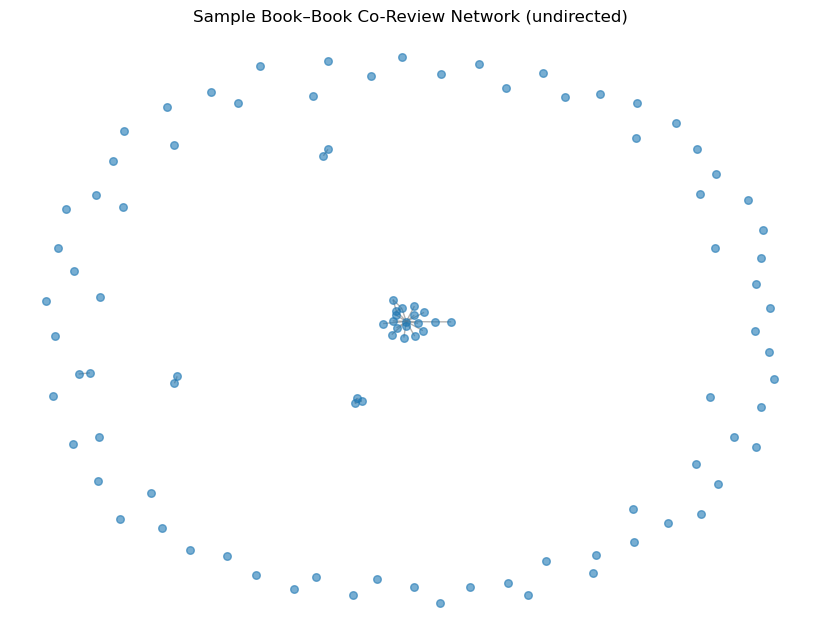

In [12]:
# ---- 2.1 Network Visualization (Sample Subgraph) ----

import networkx as nx
import matplotlib.pyplot as plt

# Convert the sparse adjacency to a NetworkX graph
G_full = nx.from_scipy_sparse_array(A_base)

# Select a small subset of nodes for visualization
sample_nodes = list(range(100))  # limit to 100 books for clarity
G_sub = G_full.subgraph(sample_nodes)

# Plot the subgraph
plt.figure(figsize=(8, 6))
nx.draw_spring(G_sub, node_size=30, edge_color="gray", alpha=0.6)
plt.title("Sample Book–Book Co-Review Network (undirected)")
plt.show()


## 3. Methods: PageRank and HITS Utilities

This section defines the main algorithms used throughout the analysis.  
- `column_stochastic(A)` converts a weighted adjacency matrix into a column-stochastic transition matrix \( P \), handling dangling columns by assigning uniform probabilities.  
- `pagerank(P)` implements the iterative PageRank computation using the standard power method.  
- `hits_scores(A)` computes HITS hub and authority scores for reference and comparison.

These utilities form the foundation for all subsequent experiments and PageRank variants.


In [13]:
# ---- 3. Methods: PageRank and HITS Utilities ----

def column_stochastic(A: csr_matrix):
    """
    Construct a column-stochastic transition matrix P from the weighted adjacency matrix A.
    Dangling columns (zero out-degree) are replaced with uniform 1/N probabilities.
    """
    A_csc = A.tocsc()
    col_sums = np.array(A_csc.sum(axis=0)).ravel()
    n = A.shape[0]

    inv = np.zeros_like(col_sums)
    nz = col_sums > 0
    inv[nz] = 1.0 / col_sums[nz]

    # Normalize each column
    D = sparse.diags(inv)
    P = A_csc @ D

    # Handle dangling columns uniformly
    dangling_cols = np.where(~nz)[0]
    if len(dangling_cols) > 0:
        uniform_col = np.full((n,), 1.0 / n, dtype=float)
        for c in dangling_cols:
            P[:, c] = csr_matrix(uniform_col).T
        P = P.tocsc()

    return P


def pagerank(P: csc_matrix, alpha=0.85, v=None, eps=EPS_TOL, max_iters=MAX_ITERS, track_error=False):
    """
    Power-iteration implementation of the PageRank algorithm:
        s_{t+1} = α * P * s_t + (1 − α) * v
    Columns of P must sum to one (column-stochastic).
    """
    n = P.shape[0]
    if v is None:
        v = np.full(n, 1.0 / n, dtype=float)
    else:
        v = np.asarray(v, dtype=float)
        v = v / v.sum()  # normalize to L1 = 1

    s = np.full(n, 1.0 / n, dtype=float)
    errs = []

    for it in range(max_iters):
        s_new = alpha * (P @ s) + (1.0 - alpha) * v
        diff = np.abs(s_new - s).sum()
        if track_error:
            errs.append(diff)
        s = s_new
        if diff < eps:
            break

    out = {"scores": s, "iters": it + 1}
    if track_error:
        out["errors"] = errs
    return out


def hits_scores(A: csr_matrix, max_iter=100, tol=1e-8):
    """
    Compute HITS scores (hubs and authorities) on the undirected co-review graph.
    In this symmetric case, the two vectors are expected to be similar.
    """
    G = nx.from_scipy_sparse_array(A, edge_attribute="weight")
    hubs, auths = nx.hits(G, max_iter=max_iter, tol=tol, normalized=True)

    n = A.shape[0]
    hubs_arr = np.array([hubs.get(i, 0.0) for i in range(n)])
    auths_arr = np.array([auths.get(i, 0.0) for i in range(n)])
    return hubs_arr, auths_arr


## 3.1 Baseline Metrics (Popularity and Degree)

To provide reference points for PageRank analysis, several baseline indicators are computed:
- **Popularity:** total number of reviews per book.  
- **Average rating:** mean user rating.  
- **Network degree:** number of co-review connections.  
  The *unweighted degree* counts distinct co-reviewed books, while the *weighted degree* sums total co-review strength across links.

These baselines allow direct comparison between simple popularity measures and network-based prestige indices such as **PageRank**.  
The **HITS** algorithm is later included only as a consistency check.


In [15]:
# ---- 3.1 Baseline Metrics (Popularity and Degree) ----

# Popularity indicators
book_review_counts = ratings_df.groupby('b_idx').size()
book_avg_rating = ratings_df.groupby('b_idx')['rating'].mean()

# Structural indicators from the co-review graph
deg_unweighted = np.array((A_base > 0).sum(axis=1)).ravel()
deg_weighted = np.array(A_base.sum(axis=1)).ravel()


## 3.2 Baseline PageRank (Vanilla Implementation)

A standard PageRank model is computed on the undirected book–book network.  
The stochastic matrix \( P \) is derived from the weighted adjacency \( A \), and the algorithm iterates until convergence using the L1 stopping criterion.  
Different damping factors (α values) are tested to examine the sensitivity of the scores to the teleportation parameter.


In [16]:
# ---- 3.2 Baseline PageRank (Vanilla Implementation) ----

# Construct the column-stochastic transition matrix
P_base = column_stochastic(A_base)

# Run PageRank for the selected damping factors
results_pagerank = {}
for alpha in ALPHA_LIST:
    out = pagerank(P_base, alpha=alpha, v=None,
                   eps=EPS_TOL, max_iters=MAX_ITERS,
                   track_error=True)
    results_pagerank[f'vanilla_alpha_{alpha}'] = out
    print(f"[PageRank] alpha={alpha}  iters={out['iters']}  L1_err_last={out['errors'][-1]:.2e}")


[PageRank] alpha=0.85  iters=31  L1_err_last=9.47e-07
[PageRank] alpha=0.5  iters=13  L1_err_last=4.88e-07


## 3.3 Personalized PageRank 

To investigate bias toward popularity or quality, the teleport vector \( v \) in the PageRank model is adjusted to reflect specific attributes:

- **Popularity personalization:** \( v_i \propto \) number of reviewers of book *i*.  
- **Quality personalization:** \( v_i \propto \) average rating of book *i*.

These variants allow comparison between structure-driven prestige and externally defined importance measures.


In [18]:
# ---- 3.3 Personalized PageRank ----

results_ppr = {}

if RUN_PERSONALIZED_PPR:
    # (a) Popularity-based personalization: v ∝ number of reviewers per book
    v_pop = book_review_counts.reindex(range(N_books)).fillna(0).to_numpy()
    v_pop = v_pop + (v_pop.sum() == 0)  # safeguard against zero vector
    for alpha in ALPHA_LIST:
        out = pagerank(P_base, alpha=alpha, v=v_pop,
                       eps=EPS_TOL, max_iters=MAX_ITERS)
        results_ppr[f'pop_alpha_{alpha}'] = out

    # (b) Quality-based personalization: v ∝ average rating per book
    v_qual = book_avg_rating.reindex(range(N_books)).fillna(0).to_numpy()
    if np.allclose(v_qual.sum(), 0.0):  # fallback if missing ratings
        v_qual = None

    for alpha in ALPHA_LIST:
        out = pagerank(P_base, alpha=alpha, v=v_qual,
                       eps=EPS_TOL, max_iters=MAX_ITERS)
        results_ppr[f'qual_alpha_{alpha}'] = out

    # Display iteration summary for personalized runs
    for key, out in results_ppr.items():
        print(f"[Personalized PR] {key}  iters={out['iters']}")


[Personalized PR] pop_alpha_0.85  iters=51
[Personalized PR] pop_alpha_0.5  iters=15
[Personalized PR] qual_alpha_0.85  iters=38
[Personalized PR] qual_alpha_0.5  iters=13


## 3.4 HITS and Centrality Consistency Check

HITS is computed on the same co-review graph to verify consistency with PageRank rankings.  
Since the network is undirected, hub and authority scores are expected to be similar.  
This step serves only as a methodological check, not for quantitative comparison.


In [19]:
# ---- 3.4 HITS and Centrality Consistency Check ----

hits_hubs, hits_auth = (np.array([]), np.array([]))

if RUN_HITS_AND_CENTRAL:
    # Compute HITS scores on the undirected co-review graph
    hits_hubs, hits_auth = hits_scores(A_base)

    # Display a brief sample for consistency verification
    print("HITS hubs (first 10):", hits_hubs[:10])
    print("HITS auth (first 10):", hits_auth[:10])
    print("Total books:", len(hits_hubs))


HITS hubs (first 10): [ 8.69716103e-07  2.41534569e-06  3.98470954e-09  1.25608516e-07
  3.13409390e-08 -5.91398236e-24  1.13541305e-06  1.33769579e-10
  1.88892365e-06  1.42472935e-09]
HITS auth (first 10): [8.69716103e-07 2.41534569e-06 3.98470954e-09 1.25608516e-07
 3.13409390e-08 1.62134622e-20 1.13541305e-06 1.33769579e-10
 1.88892365e-06 1.42472935e-09]
Total books: 50000


## 3.5 Temporal Decay PageRank

A time-weighted version of the co-review network is constructed to emphasize recent interactions.  
Edge weights are adjusted using an exponential decay function \( e^{-\lambda \cdot \text{age}} \),  
where \( \lambda \) corresponds to a chosen half-life period.  
PageRank is then recomputed on the decayed graph to assess how recency affects node importance.


In [20]:
# ---- 3.5 Temporal Decay PageRank ----

results_decay = {}

if RUN_TEMPORAL_DECAY:
    # Build a time-decayed version of the co-review graph
    A_decay, edges_decay = build_coreviews(
        ratings_df,
        tau=EDGE_THRESHOLD_TAU,
        use_decay=True,
        decay_lambda=DECAY_LAMBDA
    )

    # Save edge list for reference
    edges_decay.to_parquet(os.path.join(DATA_DIR_PROCESSED, "edges_decay.parquet"))

    # Construct column-stochastic transition matrix
    P_decay = column_stochastic(A_decay)

    # Run PageRank on the decayed graph
    for alpha in ALPHA_LIST:
        out = pagerank(P_decay, alpha=alpha, v=None,
                       eps=EPS_TOL, max_iters=MAX_ITERS)
        results_decay[f'decay_alpha_{alpha}'] = out

    # Display iteration summary for decay runs
    for key, out in results_decay.items():
        print(f"[Decay PR] {key}  iters={out['iters']}")


[Decay PR] decay_alpha_0.85  iters=25
[Decay PR] decay_alpha_0.5  iters=12


## 3.6 Reviewer Reputation PageRank

Each user receives a reputation score \( C_u \) that measures how closely the user’s ratings align with a global notion of book prestige.  
Formally:  
\[
C_u = \max \big( 0,\; \mathrm{corr}(\text{user ratings},\; \text{baseline PageRank of reviewed books}) \big)
\]

Negative correlations are truncated to zero to avoid assigning influence to users whose ratings systematically oppose the prestige signal.  
These \( C_u \) values weight shared-reviewer contributions when constructing the co-review graph, after which PageRank is recomputed on the reputation-weighted network.



In [21]:
# ---- 3.6 Reviewer Reputation PageRank ----

def compute_user_reputation(ratings, pr_scores):
    """
    Compute C_u = max(0, corr(user_ratings, PR(book))) for each user u.
    Pearson correlation is used; returns dict {u_idx: C_u}.
    """
    by_user = ratings.groupby('u_idx')
    C = {}
    for u, g in by_user:
        r = g['rating']
        if r.isna().all() or len(g) < 2:
            C[u] = 0.0
            continue
        pr = pr_scores[g['b_idx']].flatten()

        # drop NaNs
        mask = ~np.isnan(r.values) & ~np.isnan(pr)
        if mask.sum() < 2:
            C[u] = 0.0
            continue

        corr, _ = pearsonr(r.values[mask], pr[mask])
        C[u] = max(0.0, corr if not np.isnan(corr) else 0.0)
    return C

results_rep = {}

if RUN_REVIEWER_REP:
    # Use baseline vanilla PR (alpha=0.85) as prestige proxy for C_u
    pr0 = results_pagerank.get('vanilla_alpha_0.85', list(results_pagerank.values())[0])['scores']
    C_u = compute_user_reputation(ratings_df, pr0)

    # Save reputation scores (object dict; load with allow_pickle=True)
    np.save(os.path.join(DATA_DIR_PROCESSED, "user_reputation.npy"), C_u)

    # Rebuild edges weighted by reputation
    A_rep, edges_rep = build_coreviews(
        ratings_df,
        tau=EDGE_THRESHOLD_TAU,
        use_decay=False,
        user_reputation=C_u
    )
    edges_rep.to_parquet(os.path.join(DATA_DIR_PROCESSED, "edges_rep.parquet"))

    # Transition matrix and PageRank on reputation-weighted graph
    P_rep = column_stochastic(A_rep)
    for alpha in ALPHA_LIST:
        out = pagerank(P_rep, alpha=alpha, v=None,
                       eps=EPS_TOL, max_iters=MAX_ITERS)
        results_rep[f'rep_alpha_{alpha}'] = out

    # Summary of iterations for reputation-weighted runs
    for key, out in results_rep.items():
        print(f"[Reputation PR] {key}  iters={out['iters']}")


[Reputation PR] rep_alpha_0.85  iters=27
[Reputation PR] rep_alpha_0.5  iters=13


## 4. Metrics Aggregation & Top-K Tables

A consolidated metrics table is built to compare popularity, connectivity, and PageRank variants.  
Columns include review counts, weighted degree, baseline PageRank, and optional variants (personalized, temporal, reputation).  
Top-K tables are then extracted to illustrate differences between popularity and prestige.


In [22]:
# ---- 4.1 Build consolidated metrics table ----

df_metrics = pd.DataFrame(index=range(N_books))

# Baselines
df_metrics["review_count"] = (
    book_review_counts.reindex(range(N_books)).fillna(0).to_numpy()
)
df_metrics["deg_weighted"] = pd.Series(deg_weighted).to_numpy()

# PageRank variants
for k, out in results_pagerank.items():
    df_metrics[k] = out["scores"]
if RUN_PERSONALIZED_PPR:
    for k, out in results_ppr.items():
        df_metrics[k] = out["scores"]
if RUN_TEMPORAL_DECAY:
    for k, out in results_decay.items():
        df_metrics[k] = out["scores"]
if RUN_REVIEWER_REP:
    for k, out in results_rep.items():
        df_metrics[k] = out["scores"]

# Optional: HITS (consistency check)
if RUN_HITS_AND_CENTRAL:
    df_metrics["hits_hubs"] = hits_hubs
    df_metrics["hits_auth"] = hits_auth

# Attach original IDs; ensure unique columns
df_metrics["book_id"] = df_metrics.index.map(idx2book)
df_metrics = df_metrics.loc[:, ~pd.Index(df_metrics.columns).duplicated()]

print(df_metrics.shape, "unique columns:", df_metrics.columns.is_unique)


(50000, 15) unique columns: True


In [23]:
# ---- 4.2 Top-K Extraction Function ----
def topk(df, col, k=20):
    base = ["book_id", "review_count", "deg_weighted"]
    cols = base + ([col] if col not in base else [])
    return (
        df.loc[:, cols]
        .sort_values(col, ascending=False)
        .head(k)
        .reset_index(drop=True)
    )


In [30]:
# --- Top-20 tables  ---

# Popularity Top-20
top20_pop = topk(df_metrics, 'review_count')

# Prestige (PageRank) Top-20
top20_pr = topk(df_metrics, 'vanilla_alpha_0.85')  # fixed column used above

# Clean display names (stable, no fancy symbols)
top20_pr_display = top20_pr.rename(columns={
    'review_count': 'Popularity (#Reviews)',
    'deg_weighted': 'Connectivity (Weighted Degree)',
    'vanilla_alpha_0.85': 'Prestige (PageRank a=0.85)',  # plain 'a=' avoids wrap
})

from IPython.display import display
display(top20_pr_display.head(10))


,book_id,Popularity (#Reviews),Connectivity (Weighted Degree),Prestige (PageRank a=0.85)
0,B000Q032UY,7214,323674.0,0.003300
1,B000GQG5MA,7260,318028.0,0.003234
2,B0006CBNKI,1806,157144.0,0.001987
3,B000JJVHZE,1806,157144.0,0.001987
4,B0007DRGI4,1806,158074.0,0.001985
5,B000K7WNQW,1804,156940.0,0.001983
6,B000PCESRE,1614,129688.0,0.001766
7,B000I3NFKG,1604,128510.0,0.001746
8,B000NDSX6C,3624,163333.0,0.001450
9,B000GQG7D2,3640,161049.0,0.001408


In [ ]:
# 5. Visual Analysis & Correlation

This section visualizes and compares the ranking outcomes obtained from different metrics.  
The plots illustrate how **popularity** (number of reviews) diverges from **prestige** (PageRank),  
and how these measures relate across all computed variants.  
Together, they provide an intuitive understanding of how the network structure reshapes apparent importance beyond simple popularity counts.


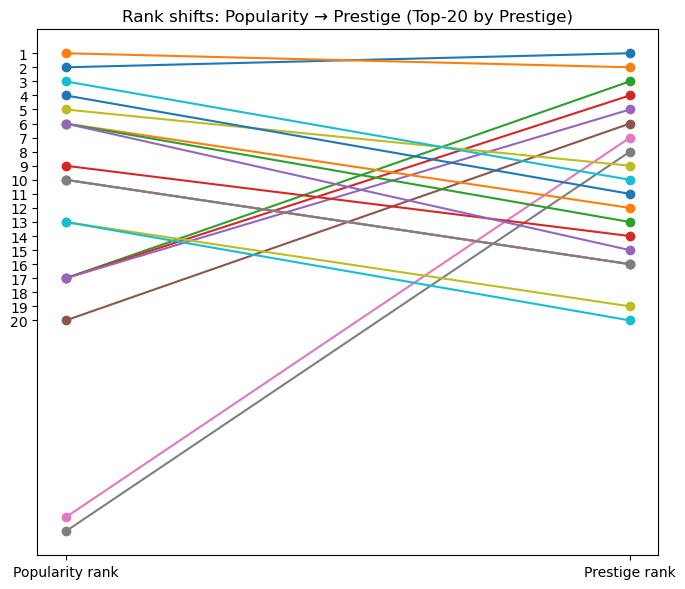

In [26]:
# ---- 5.1 Rank Shifts (Popularity → Prestige) ----
r_pop = df_metrics["review_count"].rank(ascending=False, method="min")
r_pr = df_metrics["vanilla_alpha_0.85"].rank(ascending=False, method="min")

ids = r_pr <= 20
sl = pd.DataFrame({
    "book_id": df_metrics.loc[ids, "book_id"],
    "rank_pop": r_pop[ids].astype(int),
    "rank_pr": r_pr[ids].astype(int)
}).sort_values("rank_pr")

plt.figure(figsize=(7, 6))
for _, row in sl.iterrows():
    plt.plot([0, 1], [row["rank_pop"], row["rank_pr"]], marker="o")
plt.gca().invert_yaxis()
plt.xticks([0, 1], ["Popularity rank", "Prestige rank"])
plt.yticks(range(1, 21))
plt.title("Rank shifts: Popularity → Prestige (Top-20 by Prestige)")
plt.tight_layout()
plt.show()


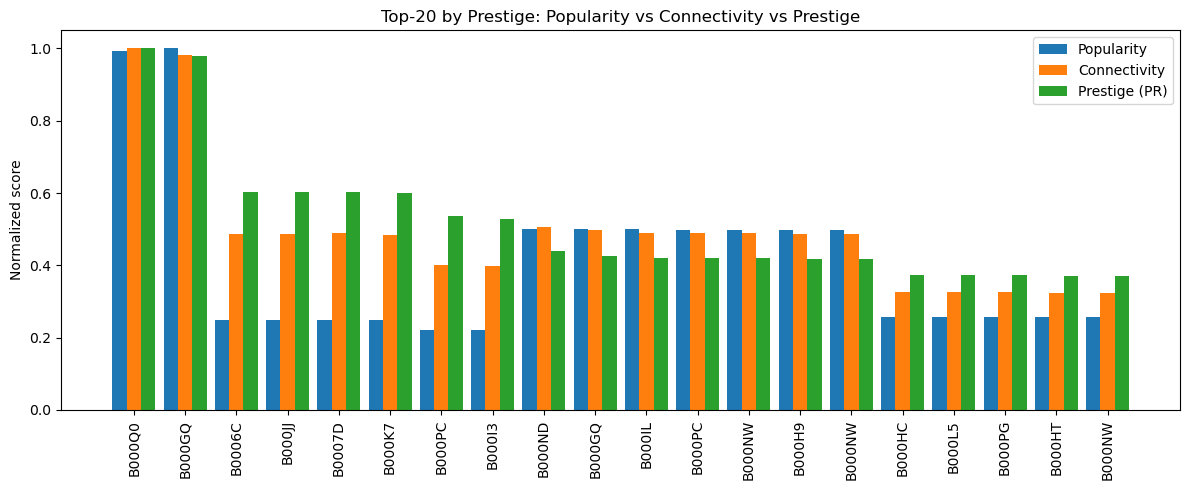

In [27]:
# ---- 5.2 Comparison Bars (Top-20 by Prestige) ----
k = 20
top_pr_ids = df_metrics.sort_values("vanilla_alpha_0.85", ascending=False).head(k).index
dfb = df_metrics.loc[top_pr_ids,
                     ["book_id","review_count","deg_weighted","vanilla_alpha_0.85"]].copy()

dfb["pop_norm"] = dfb["review_count"] / dfb["review_count"].max()
dfb["deg_norm"] = dfb["deg_weighted"] / dfb["deg_weighted"].max()
dfb["pr_norm"]  = dfb["vanilla_alpha_0.85"] / dfb["vanilla_alpha_0.85"].max()

x = np.arange(len(dfb))
w = 0.28
plt.figure(figsize=(12, 5))
plt.bar(x - w, dfb["pop_norm"], width=w, label="Popularity")
plt.bar(x,      dfb["deg_norm"], width=w, label="Connectivity")
plt.bar(x + w,  dfb["pr_norm"],  width=w, label="Prestige (PR)")
plt.xticks(x, dfb["book_id"].str.slice(0, 6), rotation=90)
plt.ylabel("Normalized score")
plt.title("Top-20 by Prestige: Popularity vs Connectivity vs Prestige")
plt.legend()
plt.tight_layout()
plt.show()


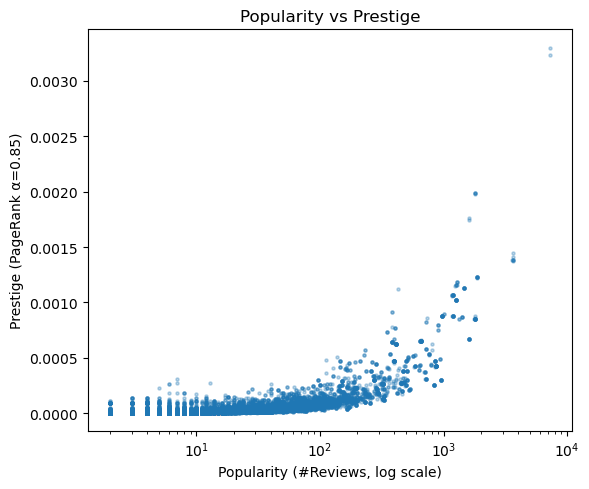

In [28]:
# ---- 5.3 Scatter: Popularity vs Prestige ----
x = df_metrics["review_count"].values
y = df_metrics["vanilla_alpha_0.85"].values

plt.figure(figsize=(6, 5))
plt.scatter(x, y, s=5, alpha=0.3)
plt.xscale("log")
plt.xlabel("Popularity (#Reviews, log scale)")
plt.ylabel("Prestige (PageRank α=0.85)")
plt.title("Popularity vs Prestige")
plt.tight_layout()
plt.show()


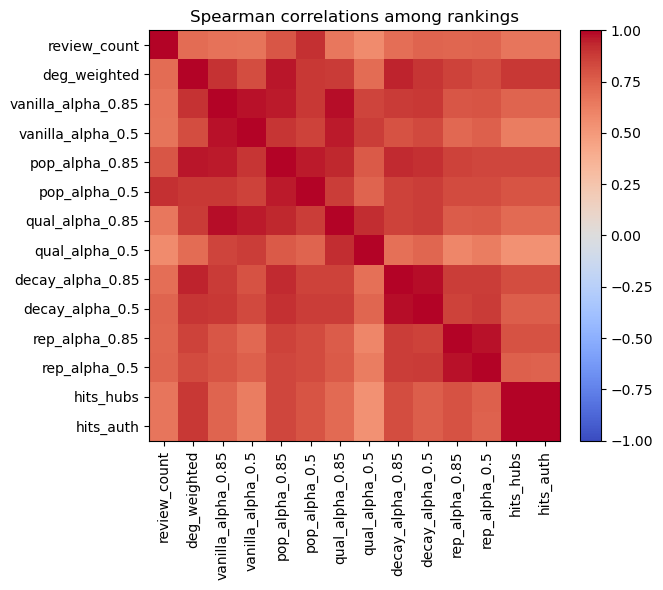

In [29]:
# ---- 5.5 Spearman Correlation Heatmap ----
cols = ["review_count","deg_weighted"] + \
       [c for c in df_metrics.columns if "alpha" in c] + \
       [c for c in ["hits_hubs","hits_auth"] if c in df_metrics.columns]

cmat = df_metrics[cols].corr(method="spearman")

plt.figure(figsize=(7, 6))
im = plt.imshow(cmat, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(cols)), cols, rotation=90)
plt.yticks(range(len(cols)), cols)
plt.title("Spearman correlations among rankings")
plt.tight_layout()
plt.show()


# 6. Extended Analyses: Personalization and Temporal Effects


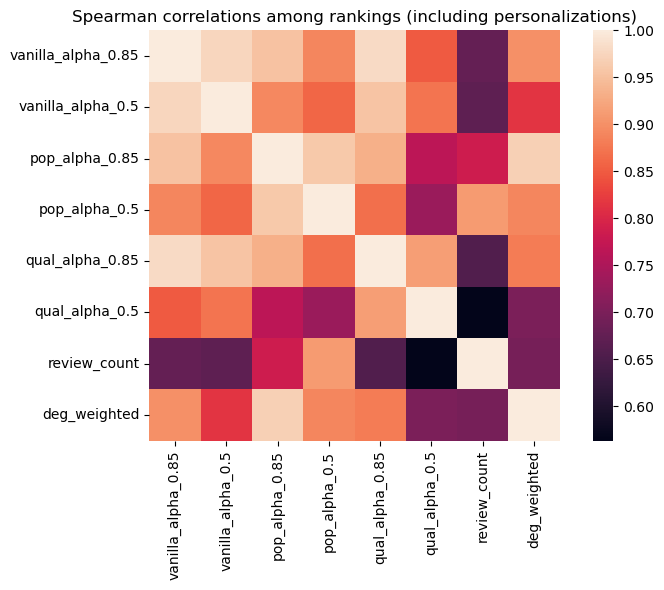

In [33]:
# ---- 6.1 Correlation Heatmap (Personalizations) ----
import seaborn as sns
import matplotlib.pyplot as plt

heat_cols = [
    c for c in df_metrics.columns
    if any(x in c for x in ['vanilla','pop_alpha','qual_alpha'])
] + ['review_count','deg_weighted']
heat_cols = [c for c in heat_cols if c in df_metrics.columns]

cmat = df_metrics[heat_cols].corr(method='spearman')

plt.figure(figsize=(8,6))
sns.heatmap(cmat, annot=False, square=True, cbar=True)
plt.title("Spearman correlations among rankings (including personalizations)")
plt.tight_layout()
plt.show()


non-zero moves: 14 of 20


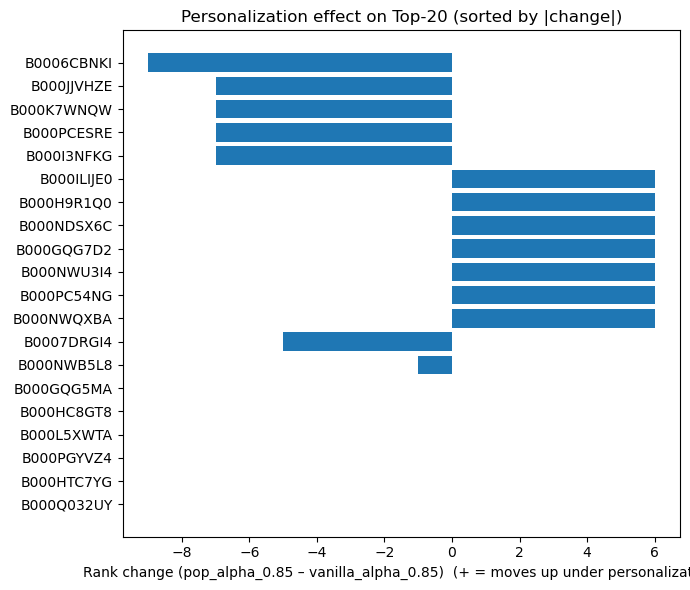

In [35]:
# ---- 6.2 Rank Shifts under Personalization ----
# define columns to compare
base_col = 'vanilla_alpha_0.85'     # baseline PR
ppr_col  = 'pop_alpha_0.85'         # or 'qual_alpha_0.85'

# build ranks with the names 6.2 uses
base_rank = df_metrics[base_col].rank(ascending=False, method='min')
ppr_rank  = df_metrics[ppr_col].rank(ascending=False, method='min')

# top-20 by the baseline PR
top20_idx = df_metrics.sort_values(base_col, ascending=False).head(20).index

nz = (base_rank.loc[top20_idx] - ppr_rank.loc[top20_idx]).astype(int)
print("non-zero moves:", (nz != 0).sum(), "of", len(nz))

delta_sorted = nz.reindex(nz.abs().sort_values(ascending=False).index)

plt.figure(figsize=(7,6))
plt.barh(range(len(delta_sorted)), delta_sorted.values)
plt.yticks(range(len(delta_sorted)), df_metrics.loc[delta_sorted.index, 'book_id'])
plt.xlabel(f"Rank change ({ppr_col} – {base_col})  (+ = moves up under personalization)")
plt.title("Personalization effect on Top-20 (sorted by |change|)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


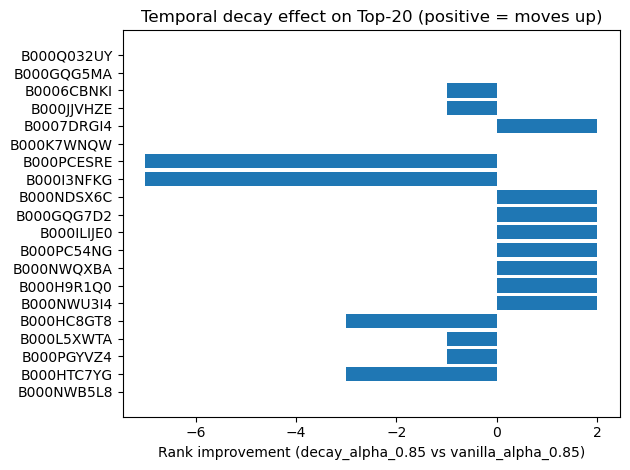

In [37]:
# ---- 6.3 Temporal Decay Rank Shifts ----
import matplotlib.pyplot as plt

if RUN_TEMPORAL_DECAY:
    base_candidates  = [c for c in df_metrics.columns if c.startswith('vanilla_alpha_')]
    decay_candidates = [c for c in df_metrics.columns if c.startswith('decay_alpha_')]
    if base_candidates and decay_candidates:
        key_base  = 'vanilla_alpha_0.85' if 'vanilla_alpha_0.85' in df_metrics.columns else base_candidates[0]
        key_decay = 'decay_alpha_0.85'   if 'decay_alpha_0.85'   in df_metrics.columns else decay_candidates[0]

        pr_base  = df_metrics[key_base]
        pr_decay = df_metrics[key_decay]

        base_rank  = pr_base.rank(ascending=False, method='min')
        decay_rank = pr_decay.rank(ascending=False, method='min')

        top20_idx = pr_base.sort_values(ascending=False).head(20).index
        delta = (base_rank.loc[top20_idx] - decay_rank.loc[top20_idx]).astype(int)

        plt.figure()
        plt.barh(range(len(top20_idx)), delta.values)
        plt.yticks(range(len(top20_idx)), df_metrics.loc[top20_idx, 'book_id'])
        plt.xlabel(f"Rank improvement ({key_decay} vs {key_base})")
        plt.title("Temporal decay effect on Top-20 (positive = moves up)")
        plt.gca().invert_yaxis()
        plt.tight_layout(); plt.show()


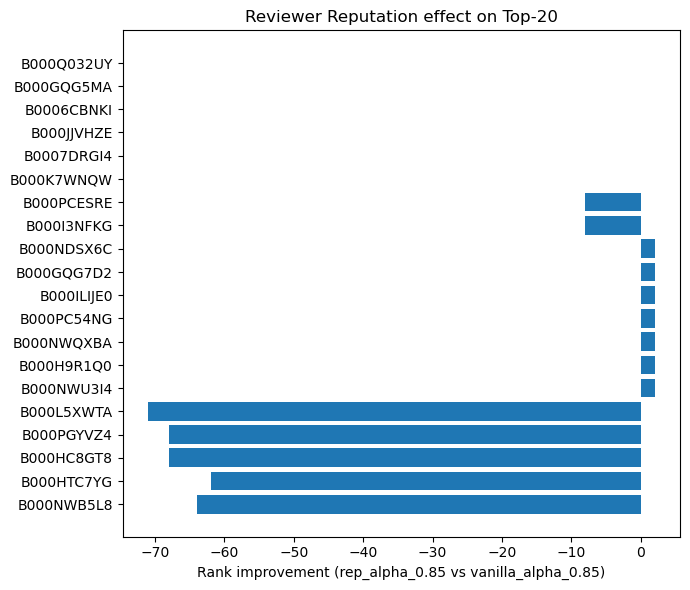

In [38]:
# ---- 6.4 Reviewer Reputation Rank Shifts ----
import matplotlib.pyplot as plt

if RUN_REVIEWER_REP and 'rep_alpha_0.85' in df_metrics.columns:
    base_col = 'vanilla_alpha_0.85' if 'vanilla_alpha_0.85' in df_metrics.columns \
               else [c for c in df_metrics.columns if 'vanilla' in c][0]
    rep_col  = 'rep_alpha_0.85'

    base_rank = df_metrics[base_col].rank(ascending=False, method='min')
    rep_rank  = df_metrics[rep_col].rank(ascending=False, method='min')

    top20_idx = base_rank.sort_values().head(20).index  # smallest rank = best
    delta = (base_rank.loc[top20_idx] - rep_rank.loc[top20_idx]).astype(int)

    plt.figure(figsize=(7,6))
    plt.barh(range(len(top20_idx)), delta.values)
    plt.yticks(range(len(top20_idx)), df_metrics.loc[top20_idx,'book_id'])
    plt.xlabel(f"Rank improvement ({rep_col} vs {base_col})")
    plt.title("Reviewer Reputation effect on Top-20")
    plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()


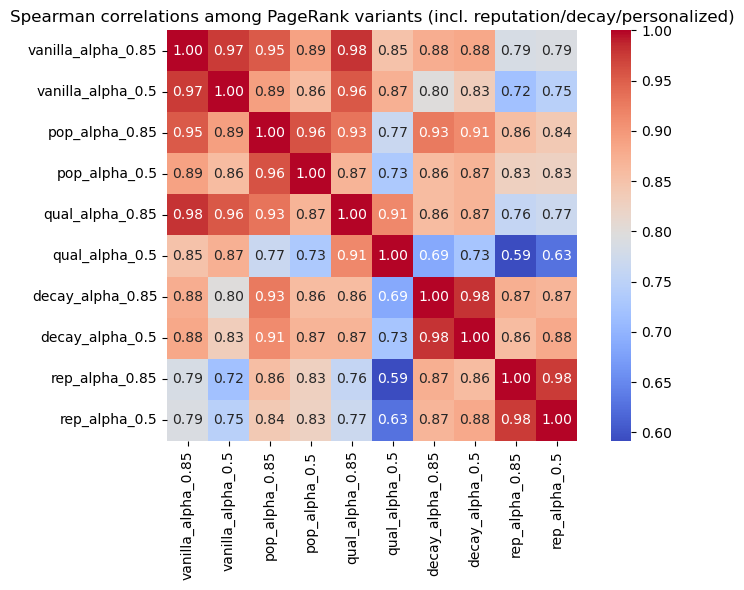

In [39]:
# ---- 6.5 Correlation Heatmap: All Variants incl. RRR ----
import seaborn as sns
import matplotlib.pyplot as plt

cols_rrr = [c for c in df_metrics.columns
            if any(x in c for x in ['vanilla','rep_alpha','decay','pop_alpha','qual_alpha'])]
cmat_rrr = df_metrics[cols_rrr].corr(method='spearman')

plt.figure(figsize=(8,6))
sns.heatmap(cmat_rrr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Spearman correlations among PageRank variants (incl. reputation/decay/personalized)")
plt.tight_layout(); plt.show()


## 6.6 Genre-Specific PageRank

This extension evaluates influence **within genres**.  
For each of the top genres by frequency, a local co-review graph is built and PageRank is computed on the genre subgraph.  
Results highlight whether prestige inside a genre aligns with in-genre popularity, and provide Top-20 lists per genre.

Outputs:
- Top-20 tables per genre (prestige vs in-genre popularity)
- A bar chart of Spearman correlations (prestige ↔ popularity) across genres


In [46]:
# ---- 6.6 Genre-Specific PageRank (FAST via submatrix slice) ----
RUN_GENRE_SPECIAL = True

genre_top_tables, genre_corrs = {}, {}

if RUN_GENRE_SPECIAL and 'genre' in ratings_df.columns:
    # Map global book index -> genre
    bidx2genre = ratings_df.groupby('b_idx')['genre'].agg(lambda s: s.dropna().mode()[0] if not s.dropna().empty else np.nan)
    # Popularity per global book (already computed earlier)
    pop_global = book_review_counts  # Series indexed by b_idx

    # Pick top genres by frequency
    top_genres = (ratings_df['genre'].value_counts(dropna=True).head(5).index.tolist())

    for g in top_genres:
        # books belonging to genre g (global indices)
        b_in_g = bidx2genre[bidx2genre == g].index.to_numpy()
        if len(b_in_g) == 0:
            print(f"[{g}] skipped (no books).")
            continue

        # OPTIONAL speed cap: keep only top-K by in-genre popularity
        K = 5000  # tune as needed (e.g., 3000–10000)
        if len(b_in_g) > K:
            # popularity restricted to genre members
            pop_g = pop_global.reindex(b_in_g).fillna(0)
            b_in_g = pop_g.sort_values(ascending=False).head(K).index.to_numpy()

        # Build submatrix by slicing the precomputed global graph
        mask = np.zeros(A_base.shape[0], dtype=bool)
        mask[b_in_g] = True
        A_g = A_base[mask][:, mask]    # super fast slice
        if A_g.nnz == 0:
            print(f"[{g}] skipped (no edges after slice).")
            continue

        # In-genre popularity vector (aligned to local ordering)
        # local order equals the order of b_in_g in the mask
        pop_g = pop_global.reindex(b_in_g).fillna(0).to_numpy()

        # PageRank within genre
        P_g = column_stochastic(A_g)
        pr_g = pagerank(P_g, alpha=0.85)['scores'].ravel()

        # Top-20 by prestige in this genre
        top_idx = np.argsort(-pr_g)[:20]
        top20_g = pd.DataFrame({
            'book_id': [idx2book[b_in_g[i]] for i in top_idx],
            'pop_g':   pop_g[top_idx],
            'pr_g':    pr_g[top_idx]
        })
        genre_top_tables[g] = top20_g

        # Spearman rho (prestige vs popularity) within genre
        rho, _ = spearmanr(pr_g, pop_g)
        genre_corrs[g] = rho

    print("Computed genre-specific PR for:", list(genre_top_tables.keys()))

    # --- Quick illustration outputs ---
    # 1) Save each genre's Top-20 table
    out_dir = os.path.join(DATA_DIR_PROCESSED, "genre_top20")
    os.makedirs(out_dir, exist_ok=True)
    for g, tbl in genre_top_tables.items():
        tbl.to_csv(os.path.join(out_dir, f"top20_{g.replace(' ','_')}.csv"), index=False)

    # 2) Print correlations succinctly
    print("Spearman rho (prestige vs popularity) per genre:")
    for g, rho in genre_corrs.items():
        print(f"  {g}: {rho:.3f}")

else:
    print("Genre specialization skipped (flag off or no genre column).")

Computed genre-specific PR for: ["['Fiction']", 'Nan', "['Juvenile Fiction']", "['Biography & Autobiography']", "['History']"]
Spearman rho (prestige vs popularity) per genre:
  ['Fiction']: -0.007
  Nan: 0.046
  ['Juvenile Fiction']: 0.667
  ['Biography & Autobiography']: 0.600
  ['History']: 0.535


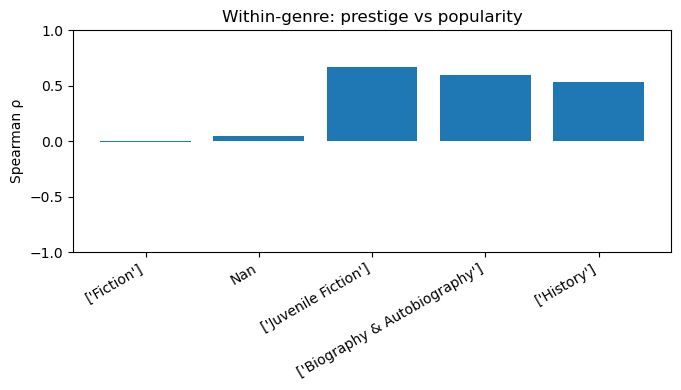

In [47]:
# Within-genre correlation (prestige vs popularity)
if RUN_GENRE_SPECIAL and genre_corrs:
    genres = list(genre_corrs.keys())
    rhos = [genre_corrs[g] for g in genres]

    plt.figure(figsize=(7,4))
    plt.bar(genres, rhos)
    plt.ylim(-1, 1)
    plt.ylabel("Spearman ρ")
    plt.title("Within-genre: prestige vs popularity")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout(); plt.show()
else:
    print("No genre correlations to plot.")


# 7. Experiments & Evaluation: Convergence

This section assesses the numerical stability and convergence speed of the PageRank iterations.  
Monitoring the decay of the L1 error across iterations helps verify that all PageRank variants  
(vanilla, personalized, temporal, reputation-weighted) converge within the set tolerance.  
Log-scaled error plots illustrate how quickly each variant stabilizes, confirming the correctness  
and efficiency of the power-iteration implementation.


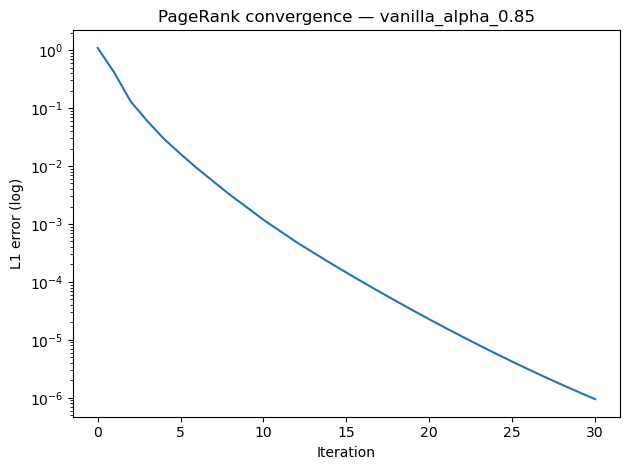

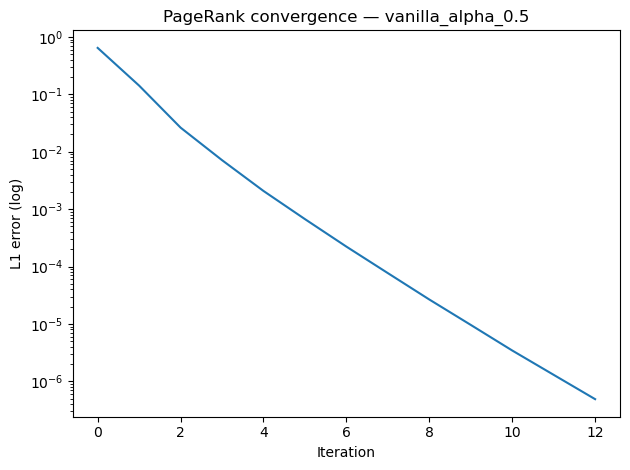

In [40]:
# ---- 7.1 PageRank Convergence Diagnostics ----
import matplotlib.pyplot as plt

for k, out in results_pagerank.items():
    if 'errors' in out and len(out['errors']):
        plt.figure()
        plt.plot(out['errors'])
        plt.yscale('log')
        plt.xlabel("Iteration")
        plt.ylabel("L1 error (log)")
        plt.title(f"PageRank convergence — {k}")
        plt.tight_layout(); plt.show()


# 8. Reproducibility & Export

The final step stores all computed metrics and rankings in a single processed file.  
This ensures full reproducibility and enables downstream analysis or visualization  
Saving the `book_metrics.parquet` file preserves every PageRank variant,  
centrality measure, and baseline feature for future use.


In [49]:
# ---- 8.1 Save Master Metrics ----
df_metrics.to_parquet(os.path.join(DATA_DIR_PROCESSED, "book_metrics.parquet"))
print("All done.")


All done.
